# Computer Vision & Deep Learning - Generative AI & Visual Synthesis

# Exercise 4: Convolutional Neural Networks

**Due on 24.05.2024., 10:00**

## Important notes

- Email: Frequently check your email address registered for Moodle. All notifications regarding the course will be sent via Moodle.
- Moodle: Please use the Moodle platform and post your questions to the forum. They will be answered by us or your fellow students.
-  Submission: Put your code and potentially other materials inside a single ZIP file. If you use jupyter notebooks, please always create a PDF file and include it in your ZIP file. The final submission should therefore be a **single zip** file with a **PDF of your code** and the **original code** inside. The ZIP file should contain your surname and your matriculation number (Surname-MatriculationNumber.zip). Submissions that fail to follow the naming convention will not be graded!

In [1]:
import os
import scipy
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms as T

---
## Task 4: Activation and Saliency Maps

In this task, we will try to visualize what CNNs learn by means of the activation
map, which is considered to be more informative than just visualizing e.g. the
kernel weights.

### 4.1 Instantiate a pre-traind ResNet18

In [2]:
from torchvision.models import resnet18

############ your code here ############
# Instantiate your model ResNet18
# turn the model into evaluation mode
# and print out the architecture 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = resnet18(pretrained=True)
model = model.to(device)

print(model)

############ end of your code############

/Users/johannes-f/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/johannes-f/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 4.2 Intermediate Activation Maps

torch.Size([1, 1000])


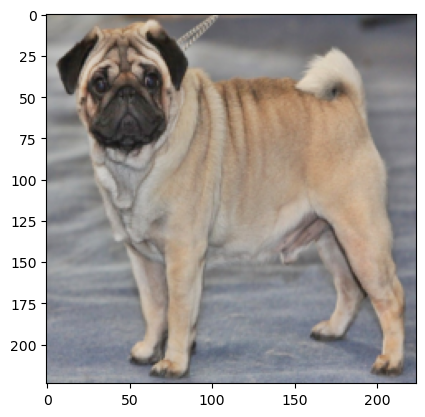

In [3]:
# check for gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load the provided image and get the output
image = Image.open('pug.jpg')
transform = T.Compose([T.Resize((224, 224)), T.ToTensor()])
X = transform(image).unsqueeze(dim=0).to(device)

def show_tensor(tensor):
    if tensor.ndim == 4:
        temp = tensor.squeeze()
    else: temp=tensor
    plt.imshow(temp.cpu().permute(1,2,0))

show_tensor(X.squeeze())

# TODO
output =  model(X)
print(output.shape)

#### Access a particular layer from the model

In [4]:
# how to access a particular layer from the model

# Note that any named layer can directly be accessed by name whereas a Sequential block’s child layers needs to be access via its index. 
# In the above example, both layer3 and downsample are sequential blocks. Hence their immediate children are accessed by index.
print(model.layer3[0].downsample[1])

BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


#### Extract activations from a layer


* 1st option remove the last layer, but this won't work for intermediate layer or multiple outputs
    ```python
    new_model = nn.Sequential(*list(model.children())[:-1])
    ```


* 2nd option, rewrite the forward method or the model class itself. Tedious and messy especially if you’re not an advanced programmer, requiring you to edit the forward block and most likely the model itself and it is likely to cause instability, when other interactions happen.
    ```python
    def _forward_impl_MY(self, x):
        ...
    model._forward_impl = MethodType(_forward_impl_my, model) 
    # for MethodType, check here: https://stackoverflow.com/questions/37455426/advantages-of-using-methodtype-in-python 
    ```


* 3rd cleanest option: attach a **forward hook** (could also be attached to backward).
Hooks are callable objects with a certain set signature that can be registered in any `nn.Module` object. When the `forward()` method is triggered in a model forward pass, the module itself, along with its inputs and outputs are passed to the **forward_hook** before proceeding to the next module. Since intermediate layers of a model are of the type `nn.module`, we can use these forward hooks on them to serve as a lens to view their activations.

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = resnet18(pretrained=True)
model = model.to(device)

#---------------Task 2.2 Store the intermediate activation maps---------------#
# adapted from https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/
############ your code here ############

# a function to call the hook signature and sotre the outputs in a dictionary
activation = {}
def getActivation(name):
    # the hook signature
    def hook(module, input, output):
        activation[name] = output.detach().cpu()
    return hook

# register forward hooks on the layers of choice
c1 = model.conv1.register_forward_hook(getActivation('conv1'))
h1 = model.avgpool.register_forward_hook(getActivation('avgpool'))
h2 = model.maxpool.register_forward_hook(getActivation('maxpool'))

# do a forward pass to store the intermediate outputs
out = model(X)

for key in activation:
    print(key)
    print(activation[key].shape)

############ end of your code############

conv1
torch.Size([1, 64, 112, 112])
maxpool
torch.Size([1, 64, 56, 56])
avgpool
torch.Size([1, 512, 1, 1])


### 4.3 Visualize the Activation Maps

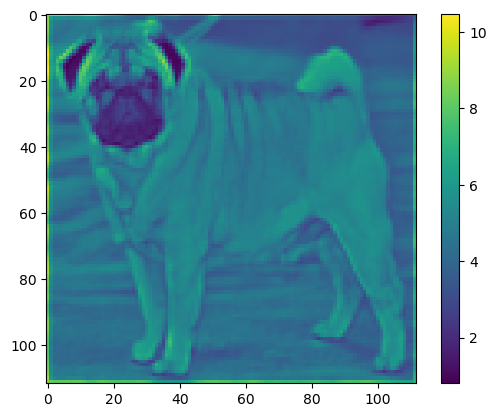

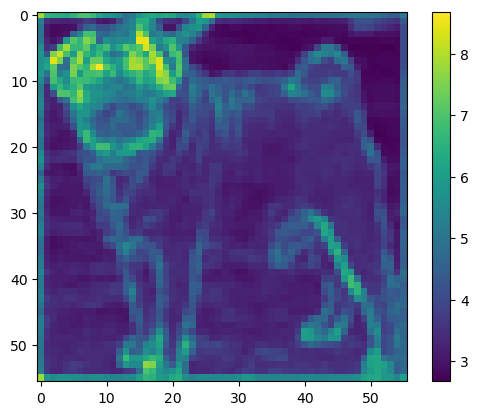

In [6]:
############ your code here ############
# reduce your activation maps' channel to a 'plottable' number
# you can use pca or any dimensionality reduction methods

plt.imshow(activation['conv1'].squeeze().norm(dim=0,keepdim=True).permute(1,2,0))
# plt.savefig('conv1.pdf')
plt.colorbar()
plt.show()
plt.imshow(activation['maxpool'].squeeze().norm(dim=0,keepdim=True).permute(1,2,0))
# plt.savefig('maxpool.pdf')
plt.colorbar()
plt.show()

############ end of your code############

The result from the maxpooling is much cleaner and sharper.

#### PCA

(56, 56, 3)


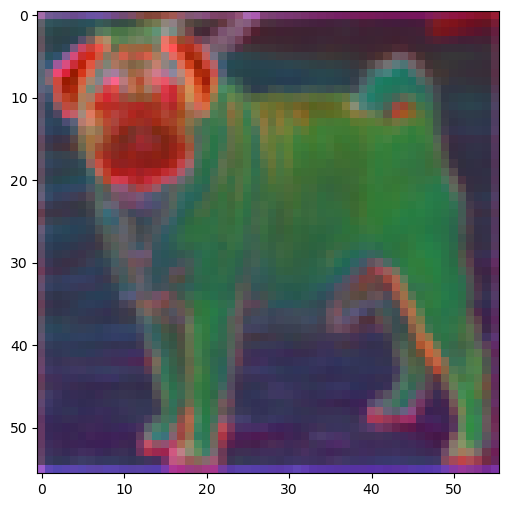

In [7]:
from sklearn.decomposition import PCA

# PCA to 3 dims
pca = PCA(n_components=3)
flat_max = activation['maxpool'].squeeze().permute(1,2,0).view(-1,64)
pca_max = pca.fit_transform(flat_max).reshape(56,56,3)
print(pca_max.shape)
# min-max normalize the pca result
pca_max = (pca_max - pca_max.min()) / (pca_max.max() - pca_max.min())

# Additionally, you can also add colorbar to it
plt.figure(figsize=(6,6))
plt.imshow(pca_max)
plt.show()

### 4.4 Plot Image and Activation Map

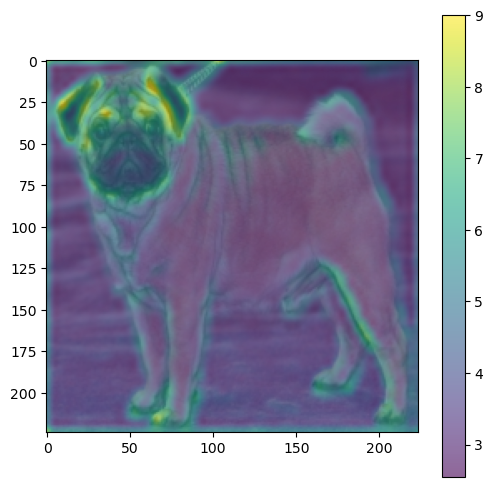

In [8]:
############ your code here ############
# visualize one of the activation maps on top of the original image
# you may need image resampling for this and the imshow(...,alpha=)
# value to overlap images with transparency.

act_max = activation['maxpool'].squeeze().norm(dim=0,keepdim=True).permute(1,2,0)
plt.figure(figsize=(6,6))
show_tensor(X)

# upsample the reduced activation map to match the original image
zoom_max = scipy.ndimage.zoom(act_max, (4,4,1), order=3)
plt.imshow(zoom_max, alpha=0.6)
plt.colorbar()
plt.show()

############ end of your code############

### 4.5 Saliency Map
Introduced in: *Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps*

In [9]:
# illustrate how gather() works
def gather_example():
    N, C = 4, 5
    s = torch.randn(N, C)
    y = torch.LongTensor([1, 2, 1, 3])
    print(s)
    print(y)
    print(s.gather(1, y.view(-1, 1)).squeeze())
gather_example()

# load the images
names = ['catdog_243.png', 'catdog_243.png', 'snake_56.png', 'spider_72.png']

X = [np.array(Image.open(name).convert('RGB')) for name in names]
y = [int(s.rsplit('_')[1].rsplit('.')[0]) for s in names]
print(y)

# intentionally change the label to a wrong one
y[1] = 285

def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Lambda(lambda x: x[None]),  # equivalent to unsqueeze()
    ])
    return transform(img)

tensor([[-0.4073, -0.4570, -1.5828, -1.3153,  0.1794],
        [-0.2402,  2.1883,  0.0043,  0.3669,  1.0917],
        [ 1.0764, -0.4245, -1.6162, -0.6132,  1.5649],
        [ 0.7247, -0.7435,  0.9125, -0.6127, -0.4050]])
tensor([1, 2, 1, 3])
tensor([-0.4570,  0.0043, -0.4245, -0.6127])
[243, 243, 56, 72]


#### a) Complete the saliency map function.

In [10]:
def saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Wrap the input tensors in Variables
    X_var = X.clone().detach()
    X_var.requires_grad = True
    y_var = y.clone().detach()
    saliency = None

    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores, and then compute the gradients with a backward pass.               #
    ##############################################################################
    
    scores = model(X_var)
    labels_scores = scores.gather(1, y_var.view(-1, 1)).squeeze() # extract the score wrt the ground truth class
    
    loss = -torch.sum(torch.log(labels_scores)) # hand-crafted Cross Entropy loss
    loss.backward()
    
    # gradients for each images wrt to raw pixels
    images_grads = X_var.grad.data
    abs_images_grads = images_grads.abs()
    saliency, _ = abs_images_grads.max(dim=1)

    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

#### b) Visualize the original images together with the saliency maps.

Visualize the original image with the saliency maps together and provide a short discussion on why different ground truth labels with even the same input image would yield different saliency maps, for instance, the catdog_243.png image with y = 243 (bull mastiff) and y = 285 (Egyptian cat).

/Users/johannes-f/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/johannes-f/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


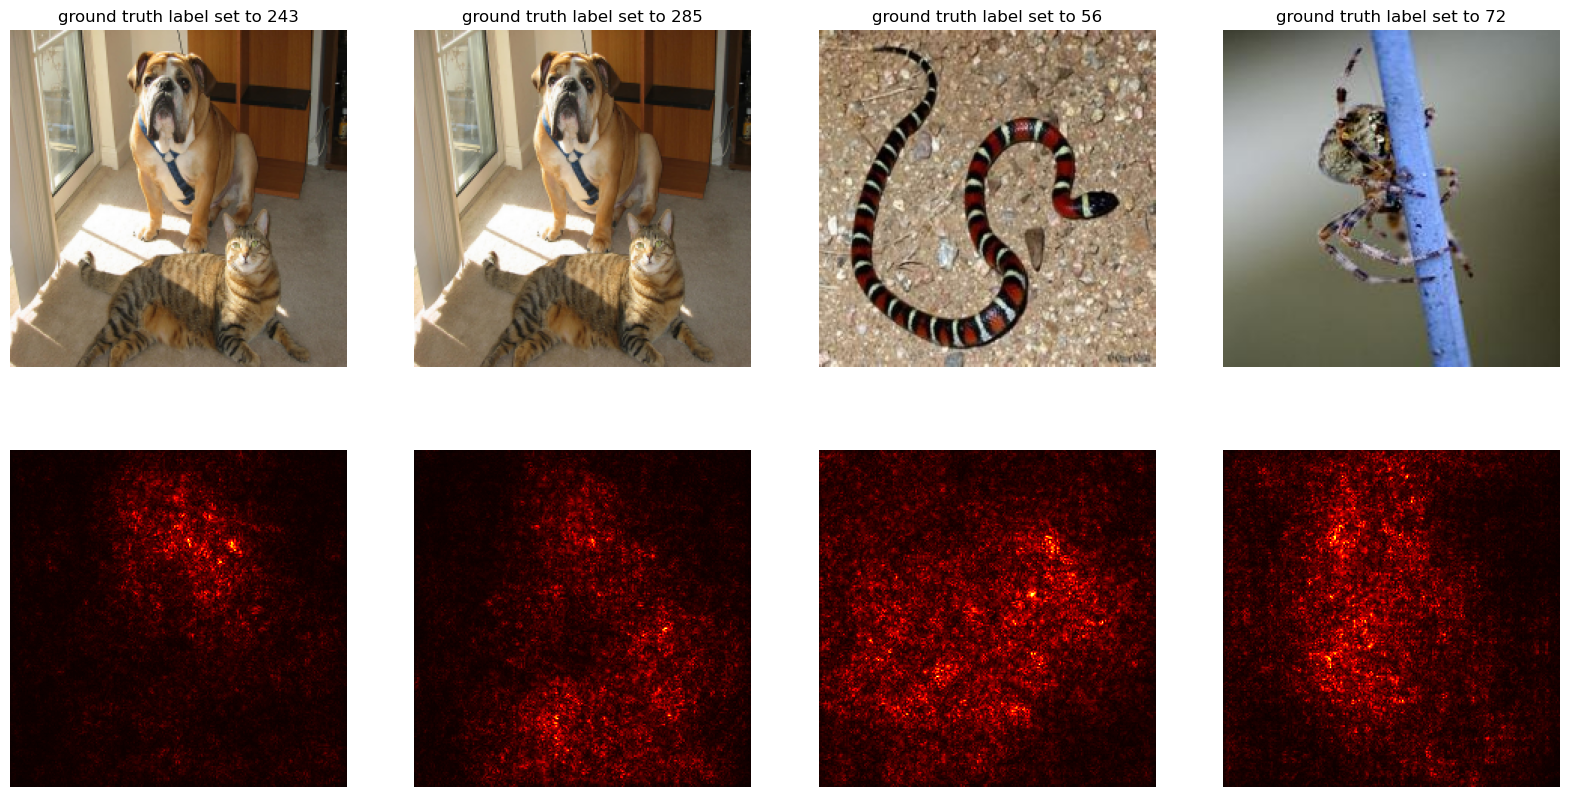

In [11]:
# Please use the same pre-trained network from the previous task for this task
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = resnet18(pretrained=True)

# if you finished the task 3.1 and defined your model, then this function should run flawlessly
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)
    # Compute saliency maps for images in X
    saliency = saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = len(X)
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title('ground truth label set to {}'.format(y[i]))
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(20, 10)
    plt.show()

show_saliency_maps(X, y)

**Why the saliency maps for the same image will be different based on differnet label/y value provided?**  
Because the gradient of your orignal image is calcluated wrt. the given label, in other words, the label (cat/dog/spider), that you are interested in, decides which final prediction score you want to extract in the following line (as they will have different scores and hence differnt losses).
```python
labels_scores = scores.gather(1, y_var.view(-1, 1)).squeeze()
```
And based on this specific loss (for individual class), you will back prop it to your image pixels with the chain rule:
```python
loss.backward()
```
Finally the magnitude of the graidnet for each pixel in your orignal image tells you, which pixel you should alter in order to decrease the loss/increase the score for the gien label. These pixels are the ones that we are interested in and the model should focus on.


This is the explaination to why would the `catdog` image have different saliency maps at the end, because in the 2nd column, the models tells you where you should alter to make it more like a `cat` in the context of what the networks was pretrained on.

---